# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly.express as px

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn import tree
from sklearn import ensemble
import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

Для выявления признаков, имеющих наибольшую корреляцию с признаком оттока, построим соответствующую тепловую карту.

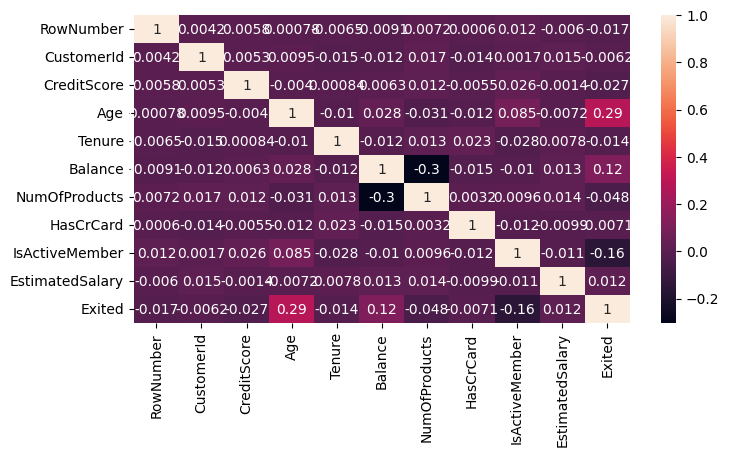

In [3]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(churn_data.corr(), annot=True);

Наибольшая корреляция наблюдается с возрастом. Посмотрим на графике.

In [4]:
fig = px.box(data_frame=churn_data,x = 'Age', color = 'Exited', height = 500, width = 700, title = 'Распределение баланса клиентов в разрезе признака оттока')
fig.show();


"Коробка" ушедших клиентов шире чем у лояльных. Возраст, что логично, оказывает влияние на окончание отношений с банком (снижение дохода в связи с выходом на пенсию, потеря заработка по причине потери работы, потери работоспособности и т.д.). Возраст ушедних клиентов - от 39 до 51 года, средний возраст в районе 45 лет.Наблюдаются "долгожители",закрывающие договор с банком начиная с 70 лет.Также есть выбросы и в более молодом поколении: 19 и 20 лет (можно предположить, что такие клиенты поторопились с заключением договора и не смогли расчитывать на долгосрочное сотрудничество с банком.Возможно возникли временные денежные потребности, да и нет еще постоянного дохода).

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [6]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [7]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [8]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [9]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [10]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [11]:
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [12]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [14]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [15]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


Как мы уже выяснили в задании 5.1., наши данные не сбалансированы, значит Accuracy нам не подходит, т.к. это ее главный недостаток.Лучше применим метрики к отдельным показателям качества классов:Precision, Recall и F-мера.Применение двух первых метрик недостаточен, т.к. необходимо найти баланс между ними, чтобы не получить ложный вывод. Для этого существует F-мера.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [165]:
log_reg = linear_model.LogisticRegression(
    #penalty='l2',
    #C=1,
    max_iter=1000,
    solver='saga', 
    random_state=42,
);

log_reg.fit(X_train_scaled, y_train);

y_train_pred_log_reg = log_reg.predict(X_train_scaled)
y_test_pred_log_reg = log_reg.predict(X_test_scaled)

print(f'Train data "F1": {metrics.f1_score(y_train, y_train_pred_log_reg):.3f}')
print(metrics.classification_report(y_train, y_train_pred_log_reg))

print(f'Test data "F1": {metrics.f1_score(y_test, y_test_pred_log_reg):.3f}')
print(metrics.classification_report(y_test, y_test_pred_log_reg))

Train data "F1": 0.490
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881

Test data "F1": 0.470
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.62      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.68      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628



F1 в идеале должен стремиться к единице, хотя надо помнить, что высокий показатель не всегда дает гарантию качества модели.
1. Для вычисления  F1 были взяты показатели по умолчанию: С=1, а тип регуляризации - L2(Ridge).F1 получился ниже установленного уровня в 0,5 у обеих выборок (см.результаты выше).
2. В дополнительном задании предложено провести экспертимент с разными типами регуляризации и коэффициентом С >1.
Тренировочная выборка достигает допустимого минимума в 0,5 при C=2 с типом Ridge(0,503),в то время как тестовая даже при высоком С не в силах достичь 0,5 (возможно я не проверила оооочень большой размер С).
При тестировании выборок с помощью регуляризации L1(Lasso), наблюдается та же картина с тестовой выборкой, при этом тренировочная выборка показала хороший результат уже при С=1.
3. В общем и целом смена типа регуляризации и установление С разного размера приводит к незначительному увеличению показателей F1.Однако, в любом случае, тестовая выборка получила результат F1 ниже установленного в условии 0,5. В связи с чем будем считать модель недообученной. 

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [166]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False);
poly.fit(X_train_scaled);

X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


log_reg_poly = linear_model.LogisticRegression(
    penalty='l2',
    C=1,
    max_iter=1000,
    solver='saga', 
    random_state=42,
);

log_reg_poly.fit(X_train_poly, y_train);

y_train_pred_log_reg_poly = log_reg_poly.predict(X_train_poly)
y_test_pred_log_reg_poly = log_reg_poly.predict(X_test_poly)

print(f'Train data "F1": {metrics.f1_score(y_train, y_train_pred_log_reg_poly):.3f}')
print(metrics.classification_report(y_train, y_train_pred_log_reg_poly))

print(f'Test data "F1": {metrics.f1_score(y_test, y_test_pred_log_reg_poly):.3f}')
print(metrics.classification_report(y_test, y_test_pred_log_reg_poly))

Train data "F1": 0.655
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1271
           1       0.78      0.56      0.66       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881

Test data "F1": 0.637
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.75       628
weighted avg       0.79      0.79      0.78       628



Показатели значительно улучшились даже в условиях "по умолчанию": С=1, а тип регуляризации- L2(Ridge). Как и в прошлом исследовании, наблюдается рост обеих выборок (более активно наблюдается прирост тренировочной выборки, в то время как при регуляризации Ridge рост F1 в тестовой выборке более медленный и останавливается при более высоком С).

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

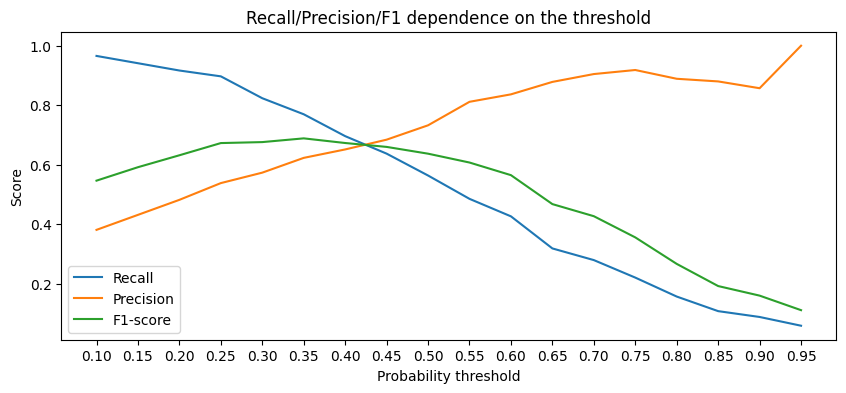

In [96]:
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)

recall_scores = []
precision_scores = []
f1_scores = []

thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
     
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))


fig, ax = plt.subplots(figsize=(10, 4)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds) 
ax.legend();

In [167]:
threshold_opt = 0.415
y_train_proba_pred = log_reg_poly.predict_proba(X_train_poly)[:, 1]
y_train_proba_pred = pd.Series(y_train_proba_pred)
y_train_pred_log_reg_poly_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_test_pred_log_reg_poly_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

print('Train data')
print(metrics.classification_report(y_train, y_train_pred_log_reg_poly_opt))
print('Test data')
print(metrics.classification_report(y_test, y_test_pred_log_reg_poly_opt))

Train data
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1271
           1       0.70      0.70      0.70       610

    accuracy                           0.80      1881
   macro avg       0.78      0.78      0.78      1881
weighted avg       0.80      0.80      0.80      1881

Test data
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       424
           1       0.68      0.68      0.68       204

    accuracy                           0.79       628
   macro avg       0.76      0.76      0.76       628
weighted avg       0.79      0.79      0.79       628



На графике наблюдается повышение Precision и падение Recall, связанное с повышением порога. При этом график F1 в интервале 0,25-0,35 чуть повышен, но после 0,35 начинает снижение.Точка пересечения (или равенства) графиков находится  в пределах 0,4-0,5, что требует произвести расчет точного порога.Баланс между Precision и Recall был достигнут на 0.415, что является оптимальным порогом вероятности.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [75]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [168]:
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy',  
    random_state=42                 
)

dt_clf_bad.fit(X_train, y_train);

y_train_pred_dt_clf_bad = dt_clf_bad.predict(X_train)
y_test_pred_dt_clf_bad = dt_clf_bad.predict(X_test)


print(f'Train data "F1": {metrics.f1_score(y_train, y_train_pred_dt_clf_bad):.3f}')
print(metrics.classification_report(y_train, y_train_pred_dt_clf_bad))

print(f'Test data "F1": {metrics.f1_score(y_test, y_test_pred_dt_clf_bad):.3f}')
print(metrics.classification_report(y_test, y_test_pred_dt_clf_bad))

print(f'Tree depth: {dt_clf_bad.get_depth()}')

Train data "F1": 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

Test data "F1": 0.569
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       424
           1       0.59      0.55      0.57       204

    accuracy                           0.73       628
   macro avg       0.69      0.68      0.69       628
weighted avg       0.72      0.73      0.73       628

Tree depth: 22


Четко видна очень большая разница между результатами тренировочной и тестовой выборок. Тем более подозрительны отличные результаты именно тренировочной выборки. Так что можно говорить о переобучении модели, что могло было произойти из-за слишком большой (неограниченной) глубины дерева. Исправить можно либо установлением ограничения на количество листов, глубины дерева, либо применить метод случайного леса

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [169]:
dt_clf = tree.DecisionTreeClassifier(
    max_depth=8,                    
    criterion='entropy',            
    min_samples_leaf=10,            
    random_state=42                 
)

dt_clf.fit(X_train, y_train);

y_train_pred_dt_clf = dt_clf.predict(X_train)
y_test_pred_dt_clf = dt_clf.predict(X_test)


print(f'Train data "F1": {metrics.f1_score(y_train, y_train_pred_dt_clf):.3f}')
print(metrics.classification_report(y_train, y_train_pred_dt_clf))

print(f'Test data "F1": {metrics.f1_score(y_test, y_test_pred_dt_clf):.3f}')
print(metrics.classification_report(y_test, y_test_pred_dt_clf))

Train data "F1": 0.717
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1271
           1       0.80      0.65      0.72       610

    accuracy                           0.83      1881
   macro avg       0.82      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881

Test data "F1": 0.640
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       424
           1       0.71      0.58      0.64       204

    accuracy                           0.79       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



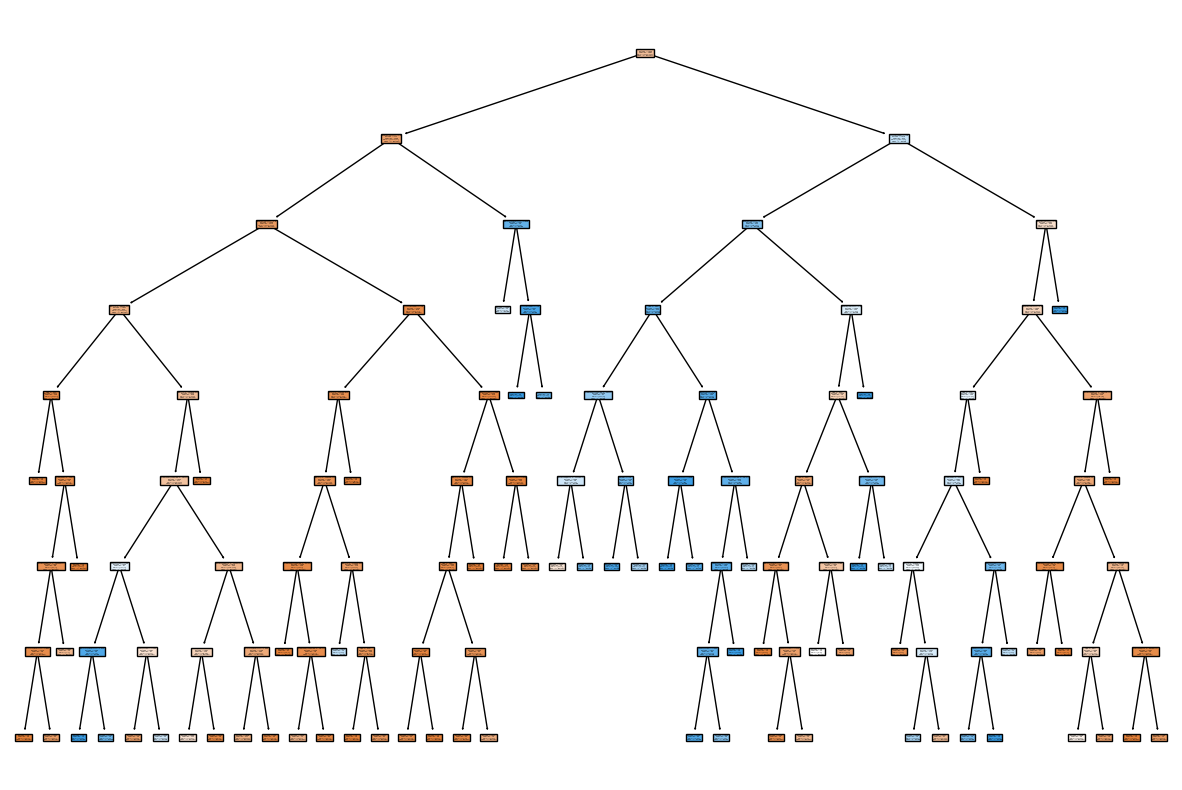

In [93]:
fig = plt.figure(figsize=(15, 10))

tree.plot_tree(
    dt_clf,                                         
    feature_names=X.columns,                            
    class_names=["0 - Not exit", "1 - Exited"],         
    filled=True,                                        
 );

Предположение, указанное выше, подтвердилось: уменьшение параметров дерева привело к некоторому улучшению более раннего расчета, а признаков переобучения теперь нет. Также уменьшение параметров дало возможность построить дерево без вызова ошибки из-за размера.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [170]:
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500,               
    max_depth=8,                    
    criterion='entropy',            
    min_samples_leaf=10,            
    random_state=42                 
)

rf_clf.fit(X_train, y_train);

y_train_pred_rf_clf = rf_clf.predict(X_train)
y_test_pred_rf_clf = rf_clf.predict(X_test)


print(f'Train data "F1": {metrics.f1_score(y_train, y_train_pred_rf_clf):.3f}')
print(metrics.classification_report(y_train, y_train_pred_rf_clf))

print(f'Test data "F1": {metrics.f1_score(y_test, y_test_pred_rf_clf):.3f}')
print(metrics.classification_report(y_test, y_test_pred_rf_clf))

Train data "F1": 0.736
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1271
           1       0.86      0.64      0.74       610

    accuracy                           0.85      1881
   macro avg       0.85      0.80      0.82      1881
weighted avg       0.85      0.85      0.84      1881

Test data "F1": 0.656
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       424
           1       0.75      0.58      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.80      0.80      0.79       628



Результаты  выборок (особенно тренировочной) снова улучшились. Это объясняется преимуществом "Случайного леса":как правило, он более точен для невидимых наборов данных, поскольку избегает переобучения обучающих наборов данных.Также такая модель строит несколько деревьев, берет среднее значение предсказаний этих деревьев, поэтому меньше подвержена выбросам.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

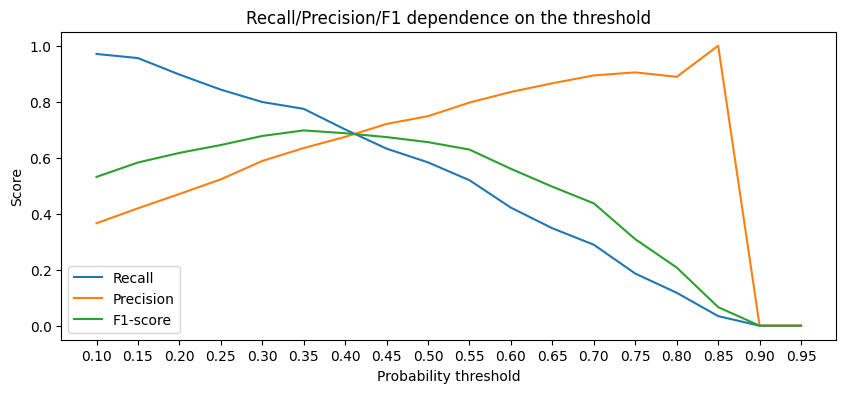

In [133]:
y_test_proba_pred = rf_clf.predict_proba(X_test)[:, 1]

y_test_proba_pred = pd.Series(y_test_proba_pred)

recall_scores = []
precision_scores = []
f1_scores = []

thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))


fig, ax = plt.subplots(figsize=(10, 4)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds) 
ax.legend();

In [140]:
threshold_opt = 0.383

y_train_proba_pred = rf_clf.predict_proba(X_train)[:, 1]
y_train_proba_pred = pd.Series(y_train_proba_pred)
y_train_pred_rf_clf_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

y_test_pred_rf_clf_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

print('Train data')
print(metrics.classification_report(y_train, y_train_pred_rf_clf_opt))

print('Test data')
print(metrics.classification_report(y_test, y_test_pred_rf_clf_opt))

Train data
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1271
           1       0.76      0.76      0.76       610

    accuracy                           0.84      1881
   macro avg       0.82      0.82      0.82      1881
weighted avg       0.84      0.84      0.84      1881

Test data
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       424
           1       0.65      0.73      0.69       204

    accuracy                           0.79       628
   macro avg       0.76      0.77      0.76       628
weighted avg       0.79      0.79      0.79       628



В качестве модели выбран "Случайный лес", т.к. она показала лучшие результаты. Однако на графике мало что поменялось. Тем не менее наблюдается относительное сглаживание "поведения" графиков до соединения, Recall и F1 и после соединения "идут" более гладко, даже в районе 0,88 соединяются. 
В точке порога растет Precision и падает Recall.Повышается точность, но уменьшается охват.
Обращает внимание и резкое падение Precision с 0,86 и соединение на пороге в 0,9 с двумя остальными графиками. 
Precision отвечает за количество положительных данных, получается, что после 0,86 их количество падает?F1 снизилась, следовательно можно было бы сказать о  расбалансированности 2х других метрик и наличии как ложноположительных, так и ложноотрицательных срабатываний, но ситуацию спасает Recall, находящийся на том же уровне.
Порог снизился с 0,415 до 0,383. 

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

Чтобы было понятно, что изучаем риск ухода именно Василия, проименуем переменные в его честь.Создадим словарь с его данными.

In [142]:
dct = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
Vasily = pd.DataFrame.from_dict(dct)

In [143]:
Vasily

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,601.0,Male,42.0,1.0,98495.72,1.0,1.0,0.0,40014.76


In [171]:
Vasily['Gender'] = Vasily['Gender'].apply(lambda x: 1 if x=='Male' else 0)

for col in Vasily.columns:
    Vasily[col] = pd.to_numeric(Vasily[col])

Vasily[['CreditScore', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']] = Vasily[[
    'CreditScore', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']].apply(int)
Vasily[['Balance', 'EstimatedSalary']] = Vasily[['Balance', 'EstimatedSalary']].astype(float)

Vasily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          1 non-null      int64  
 1   Gender               1 non-null      int64  
 2   Age                  1 non-null      int64  
 3   Tenure               1 non-null      int64  
 4   Balance              1 non-null      float64
 5   NumOfProducts        1 non-null      int64  
 6   HasCrCard            1 non-null      int64  
 7   IsActiveMember       1 non-null      int64  
 8   EstimatedSalary      1 non-null      float64
 9   BalanceSalaryRatio   1 non-null      float64
 10  TenureByAge          1 non-null      float64
 11  CreditScoreGivenAge  1 non-null      float64
dtypes: float64(5), int64(7)
memory usage: 224.0 bytes


In [163]:
Vasily['Gender'] = Vasily['Gender'].apply(lambda x: 1 if x=='Male' else 0)

for col in Vasily.columns:
    Vasily[col] = pd.to_numeric(Vasily[col])

Vasily[['CreditScore', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']] = Vasily[[
    'CreditScore', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']].apply(int)
Vasily[['Balance', 'EstimatedSalary']] = Vasily[['Balance', 'EstimatedSalary']].astype(float)


In [173]:
Vasily_scaled = scaler.transform(Vasily)

Vasily_scaled_poly = poly.transform(Vasily_scaled)

y_Vasily_proba_predict_log_reg_poly = log_reg_poly.predict_proba(Vasily_scaled_poly)

print(f'Predicted probabilities: {np.round(y_Vasily_proba_predict_log_reg_poly, 2)}')

y_Vasily_pred_log_reg_poly = log_reg_poly.predict(Vasily_scaled_poly)

print(f'Predicted class: {y_Vasily_pred_log_reg_poly}')


if y_Vasily_pred_log_reg_poly:
    print(f'The probability of the client leaving: {(y_Vasily_proba_predict_log_reg_poly[0, 1] * 100):.2f}%')
else:
    print(f'The probability of the client leaving: {(y_Vasily_proba_predict_log_reg_poly[0, 0] * 100):.2f}%')

Predicted probabilities: [[0.38 0.62]]
Predicted class: [1]
The probability of the client leaving: 61.59%


Согласно результатам модели, риск отказа Василия от услуг банка составляет 61,59%.